In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.utils import shuffle

from tools import plot_confusion_matrix

In [2]:
df = pd.read_csv('../data/datatran_2016-2017.csv', dtype={'br_str': str})
df.shape

/Users/leportella/.virtualenvs/udacity/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(180991, 32)

In [3]:
df.target.value_counts()

1    106534
0     64166
2     10291
Name: target, dtype: int64

In [4]:
class0 = df[df.target==0]
class1 = df[df.target==1].sample(54630)
class2 = df[df.target==2]


In [5]:
class0.target = 1
class1.target = 0
class2.target = 0 

df2 = shuffle(pd.concat([class0, class1, class2]))

/Users/leportella/.virtualenvs/udacity/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [6]:
dd = df2[['weekday', 'uf', 'br_str', 'km_int', 'accident_cause_simplified', 'accident_type', 
        'moment_of_day', 'climate', 'road_layout', 'target']]
dd = dd.dropna()
dd.shape

(129087, 10)

In [7]:
X = pd.get_dummies(dd.drop(['target'], axis=1))
y = dd['target']

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_PCA = pca.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.2, random_state=42)

In [10]:
model = LogisticRegression()

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1., 1.5],
    'class_weight': ['balanced', None]
}


scorer = make_scorer(score_func=accuracy_score)

grid_obj = GridSearchCV(model, parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

In [11]:
best_clf

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
joblib.dump(best_clf, '../model/model_v10-no-victms.pkl')

['../model/model_v10-no-victms.pkl']

In [12]:
y_pred = best_clf.predict(X_test)

Confusion matrix, without normalization
[[7338 5665]
 [3262 9553]]


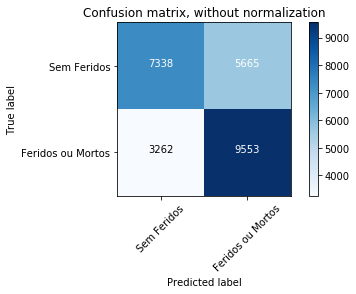

In [13]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['Sem Feridos', 'Feridos ou Mortos'],
                      title='Confusion matrix, without normalization')

In [14]:
accuracy_score(y_test, y_pred)

0.6542334805174684

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.69      0.56      0.62     13003
          1       0.63      0.75      0.68     12815

avg / total       0.66      0.65      0.65     25818



In [16]:
y_pred_proba = best_clf.predict_proba(X_test)
y_pred_proba

array([[0.45155986, 0.54844014],
       [0.47739484, 0.52260516],
       [0.32974142, 0.67025858],
       ...,
       [0.24444486, 0.75555514],
       [0.70176692, 0.29823308],
       [0.98556074, 0.01443926]])